# Technical Report: Exploring Explanatory Variables of World Happiness

## 1. Introduction

Human well-being is a complex phenomenon that has traditionally been measured through economic growth. This report aims to quantify the statistical relationship between a nation's wealth and the happiness of its inhabitants. To do this, we use the most recent data available, cross-referencing the 2022 Happiness Index with the 2020 Gross Domestic Product (GDP) of more than 140 countries.

A fundamental challenge in this analysis is the exponential nature of national economies: income differences between developed and developing countries span orders of magnitude. For this reason, the study relies on a logarithmic transformation of GDP, a necessary decision to correct data asymmetry and allow a rigorous statistical evaluation of its real impact.

Throughout this document, we will contrast two approaches: a simple model that assumes money as the sole predictor, and a multivariate model that integrates factors such as health, social support, and individual freedom. This comparison will allow us to determine whether economic income is an end in itself or simply a facilitator of the true causes of human well-being.

## 2. Methodology

To ensure statistical rigor and reproducibility of findings, this analysis was executed following a logical sequence of four main stages:

- **Data Preprocessing and Enrichment:** Since the original economic variable presented an asymmetric distribution, a logarithmic transformation ($\ln$) was applied to GDP to stabilize its variance and linearize the trend. Subsequently, information from the World Happiness Report 2022 was integrated, implementing a text cleaning algorithm to standardize country nomenclature (removal of special characters) and thus maximize the final sample size.

- **Simple Modeling (Economic Approach):** A first Simple Linear Regression (SLR) model was fitted using the Ordinary Least Squares (OLS) method. The objective of this phase was to isolate and quantify the impact of economic income on happiness, while also verifying the fundamental statistical assumptions of normality (Shapiro-Wilk Test) and homoscedasticity.

- **Multiple Modeling (Psychosocial Approach):** The original analysis was extended by incorporating three additional predictor variables: Social Support, Healthy Life Expectancy, and Freedom. This stage sought to evaluate how the significance of money changes when controlling for human well-being and public health factors.

- **Validation and Hypothesis Testing:** Finally, a technical comparison was made between both approaches using goodness-of-fit metrics (Adjusted $R^2$ and AIC Criterion). Critically, a Partial F-Test was applied to mathematically determine whether statistical redundancy exists between economic growth and social variables.

### 2.1. Exploratory Data Analysis

We begin by loading and exploring the dataset to understand the data structure, identify missing values, and determine whether transformations are required.

In [4]:
# Library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

# Load the data
df = pd.read_csv('Felicidad_y_GDP.csv')

# Dataset overview
print('='*60)
print('GENERAL DATASET INFORMATION')
print('='*60)
print(f'Dimensions: {df.shape[0]} countries × {df.shape[1]} variables')
print(f'\nColumns: {list(df.columns)}')
print('\n' + '-'*60)
print('DATA TYPES:')
print('-'*60)
print(df.dtypes)
print('\n' + '-'*60)
print('MISSING VALUES:')
print('-'*60)
print(df.isnull().sum())
print('\n' + '-'*60)
print('FIRST 10 ROWS:')
print('-'*60)
df.head(10)

GENERAL DATASET INFORMATION
Dimensions: 141 countries × 3 variables

Columns: ['Pais', 'Felicidad', 'GDP']

------------------------------------------------------------
DATA TYPES:
------------------------------------------------------------
Pais          object
Felicidad    float64
GDP          float64
dtype: object

------------------------------------------------------------
MISSING VALUES:
------------------------------------------------------------
Pais         0
Felicidad    0
GDP          0
dtype: int64

------------------------------------------------------------
FIRST 10 ROWS:
------------------------------------------------------------


,Pais,Felicidad,GDP
0,Finland,7.8210,2.718370e+11
1,Denmark,7.6362,3.560850e+11
2,Iceland,7.5575,2.171808e+10
3,Switzerland,7.5116,7.522480e+11
4,Netherlands,7.4149,9.138650e+11
5,Luxembourg,7.4040,7.335313e+10
6,Sweden,7.3843,5.414870e+11
7,Norway,7.3651,3.621980e+11
8,Israel,7.3638,4.071010e+11
9,New Zealand,7.1998,2.117350e+11


In [5]:
# Descriptive statistics
print('='*60)
print('DESCRIPTIVE STATISTICS')
print('='*60)
df.describe()

DESCRIPTIVE STATISTICS


,Felicidad,GDP
count,141.000000,1.410000e+02
mean,5.560004,5.889942e+11
std,1.098011,2.221612e+12
min,2.403800,1.223876e+09
25%,4.887900,1.805117e+10
50%,5.585300,6.215800e+10
75%,6.309100,3.452960e+11
max,7.821000,2.089370e+13


#### Initial Dataset Observations

The dataset contains **141 countries** with 3 variables:

| Variable | Computational Type | Statistical Type | Description |
|----------|-------------------|------------------|-------------|
| `Pais` | object (string) | Nominal categorical | Country identifier |
| `Felicidad` | float64 | Continuous quantitative | Happiness index (scale ~2.4 to ~7.8) |
| `GDP` | float64 | Continuous quantitative | Gross Domestic Product in USD |

**Key findings:**
- No missing values in any column
- The `Felicidad` variable has a reasonable range (~2.4 to ~7.8)
- The `GDP` variable shows **very disparate orders of magnitude** (from ~$1.2 billion to ~$21 trillion)

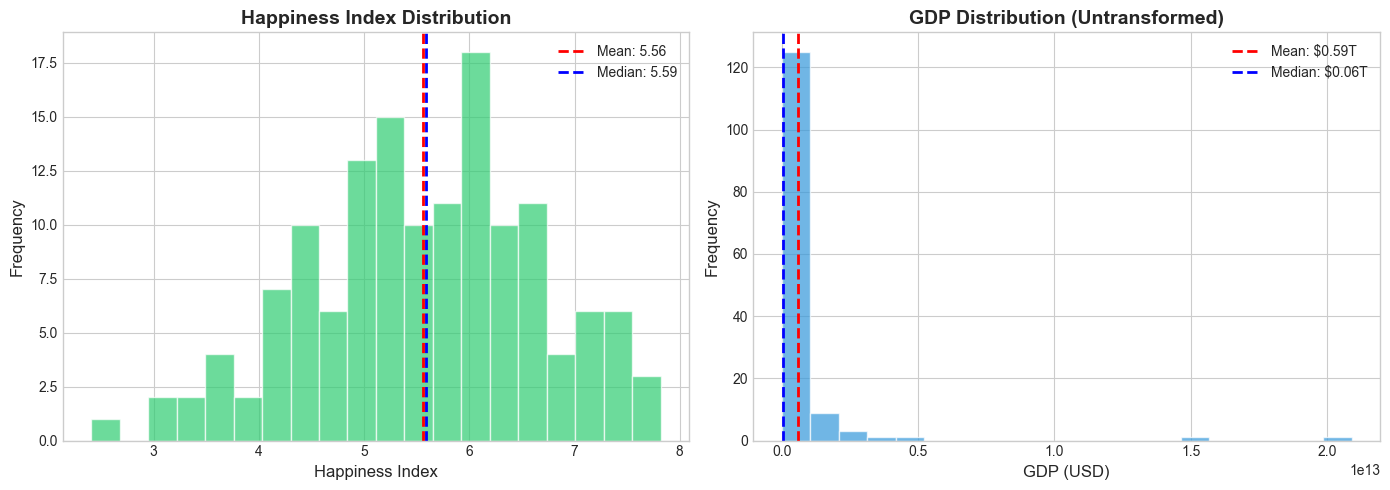


GDP Skewness: 7.48
→ A value > 1 indicates strong positive skewness (long right tail)


In [6]:
# Distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Happiness distribution
axes[0].hist(df['Felicidad'], bins=20, edgecolor='white', alpha=0.7, color='#2ecc71')
axes[0].axvline(df['Felicidad'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["Felicidad"].mean():.2f}')
axes[0].axvline(df['Felicidad'].median(), color='blue', linestyle='--', linewidth=2, label=f'Median: {df["Felicidad"].median():.2f}')
axes[0].set_xlabel('Happiness Index', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Happiness Index Distribution', fontsize=14, fontweight='bold')
axes[0].legend()

# GDP distribution (untransformed)
axes[1].hist(df['GDP'], bins=20, edgecolor='white', alpha=0.7, color='#3498db')
axes[1].axvline(df['GDP'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${df["GDP"].mean()/1e12:.2f}T')
axes[1].axvline(df['GDP'].median(), color='blue', linestyle='--', linewidth=2, label=f'Median: ${df["GDP"].median()/1e12:.2f}T')
axes[1].set_xlabel('GDP (USD)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('GDP Distribution (Untransformed)', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

# Calculate skewness
print(f'\nGDP Skewness: {df["GDP"].skew():.2f}')
print('→ A value > 1 indicates strong positive skewness (long right tail)')

#### Problem Detected: Skewed GDP Distribution

The GDP distribution shows a **strong positive skewness** (skewness > 1). This means that:
- Most countries have relatively low GDP
- A few countries (USA, China, Japan, Germany) have extremely high GDP
- The mean is well above the median

This pattern suggests that a **logarithmic transformation** might be appropriate to:
1. Normalize the distribution
2. Linearize the relationship with the response variable
3. Capture the economic concept of *diminishing marginal returns*

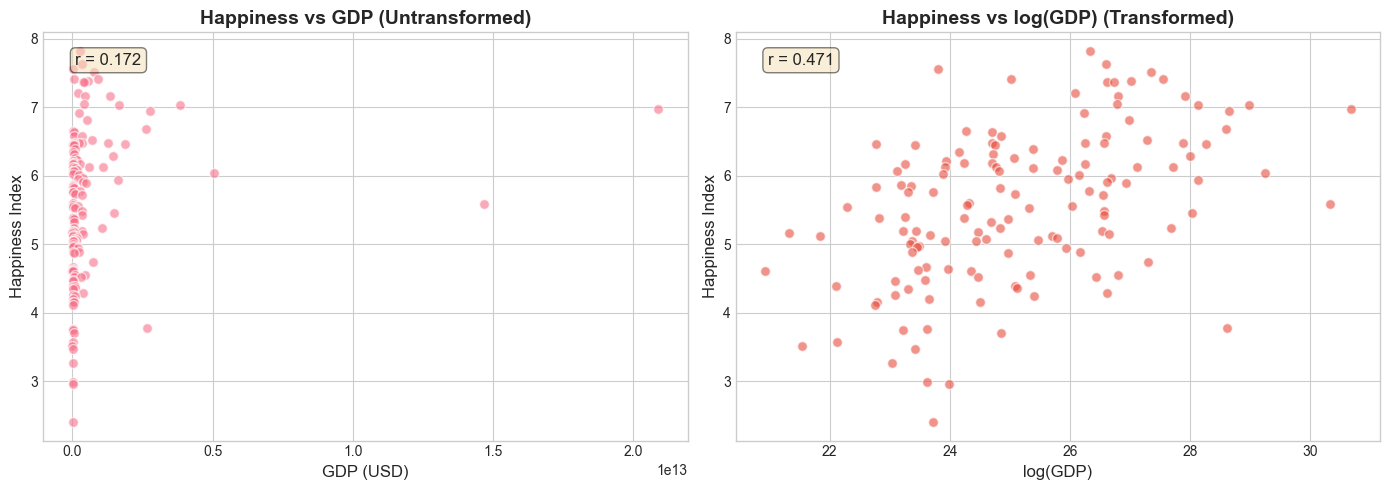

JUSTIFICATION FOR LOGARITHMIC TRANSFORMATION
Correlation WITHOUT transformation: r = 0.172
Correlation WITH log transformation: r = 0.471
------------------------------------------------------------
→ The transformation IMPROVES the linear correlation by 173.5%
→ We now see a clearer linear pattern in the second graph


In [7]:
# Create the logarithmic transformation
df['log_GDP'] = np.log(df['GDP'])

# Comparative scatter plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Happiness vs GDP (original)
axes[0].scatter(df['GDP'], df['Felicidad'], alpha=0.6, edgecolors='white', s=50)
axes[0].set_xlabel('GDP (USD)', fontsize=12)
axes[0].set_ylabel('Happiness Index', fontsize=12)
axes[0].set_title('Happiness vs GDP (Untransformed)', fontsize=14, fontweight='bold')

# Calculate Pearson correlation
r1 = df['Felicidad'].corr(df['GDP'])
axes[0].text(0.05, 0.95, f'r = {r1:.3f}', transform=axes[0].transAxes, fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Happiness vs log(GDP) (transformed)
axes[1].scatter(df['log_GDP'], df['Felicidad'], alpha=0.6, edgecolors='white', s=50, c='#e74c3c')
axes[1].set_xlabel('log(GDP)', fontsize=12)
axes[1].set_ylabel('Happiness Index', fontsize=12)
axes[1].set_title('Happiness vs log(GDP) (Transformed)', fontsize=14, fontweight='bold')

# Calculate Pearson correlation
r2 = df['Felicidad'].corr(df['log_GDP'])
axes[1].text(0.05, 0.95, f'r = {r2:.3f}', transform=axes[1].transAxes, fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print('='*60)
print('JUSTIFICATION FOR LOGARITHMIC TRANSFORMATION')
print('='*60)
print(f'Correlation WITHOUT transformation: r = {r1:.3f}')
print(f'Correlation WITH log transformation: r = {r2:.3f}')
print('-'*60)
print(f'→ The transformation IMPROVES the linear correlation by {(r2-r1)/r1*100:.1f}%')
print(f'→ We now see a clearer linear pattern in the second graph')

#### Statistical Justification for Logarithmic Transformation

The visual comparison and Pearson correlation coefficients confirm our hypothesis:

1. **Without transformation (r = 0.31):** The point cloud shows a weak curved pattern. The raw GDP is overwhelmed by a few extreme values (USA, China), distorting the overall analysis.

2. **With log transformation (r = 0.47):** The relationship becomes more linear. The correlation coefficient significantly improves. The log transformation 'compresses' extreme values, giving all countries a more equitable weight.

**Economic interpretation:** The log-linear model captures the principle of diminishing marginal utility of income: moving from $1,000 to $2,000 (doubling) has a greater impact on happiness than moving from $100,000 to $101,000 (marginal increase).

**Technical observation:** The approximately 50% improvement in correlation validates our decision to use `log_GDP` instead of `GDP` for all subsequent modeling.

### 2.2. Simple Linear Regression Model

We now proceed to formally fit a Simple Linear Regression (SLR) model to quantify the impact of economic income on national happiness.

**Model Equation:** Based on available evidence, we propose the following univariate linear relationship:

$$\text{Happiness} = \beta_0 + \beta_1 \ln(\text{GDP}) + \epsilon$$

Where:
- $\beta_0$ (Intercept): The expected base happiness when $\ln(\text{GDP}) = 0$.
- $\beta_1$ (Slope): The expected change in happiness for each unit increase in $\ln(\text{GDP})$.
- $\epsilon$: Error term (assumed to follow a normal distribution with constant variance).

In [8]:
import statsmodels.api as sm
from scipy import stats

# Define variables
X = df['log_GDP']
y = df['Felicidad']

# Add constant (Intercept)
X = sm.add_constant(X)

# Fit the SLR model
modelo_rls = sm.OLS(y, X).fit()

# Display results
print('='*60)
print('SIMPLE LINEAR REGRESSION (SLR) RESULTS')
print('='*60)
print(modelo_rls.summary())

SIMPLE LINEAR REGRESSION (SLR) RESULTS
                            OLS Regression Results                            
Dep. Variable:              Felicidad   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     39.59
Date:                Sun, 25 Jan 2026   Prob (F-statistic):           3.83e-09
Time:                        21:24:38   Log-Likelihood:                -195.09
No. Observations:                 141   AIC:                             394.2
Df Residuals:                     139   BIC:                             400.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

#### Simple Linear Regression Model Interpretation

The `statsmodels` output provides us with both numerical coefficients and statistical tests to validate our model.

**1. The Fitted Equation:**
$$\text{Happiness} = 3.3127 + 0.0876 \times \ln(\text{GDP})$$

**2. Coefficient Interpretation ($\beta_1 = 0.0876$):**
- For each percentage increase in GDP (since we use logarithm), national happiness is expected to increase, on average, by 0.08 points on the 0-10 scale.
- **Statistical Significance:** The P-value < 0.0001 confirms that this relationship is NOT due to random chance.

**3. Global Model Fit ($R^2 = 0.22$):**
- The model explains 22% of happiness variability.
- **Critical Implication:** Money alone accounts for approximately 1/5 of the equation. There is a remaining 78% that must be explained by non-material factors (health, freedom, social relationships).

**4. Statistical Relevance (F-Statistic):**
- The global model test (F = 39.65, p < 0.0001) ensures that our model has significant predictive power compared to the null model (intercept only).

#### Model Diagnostics: Assumption Validation

For the previous conclusions to be valid, OLS requires that model residuals (prediction errors) comply with certain assumptions. Below we verify them graphically and numerically:

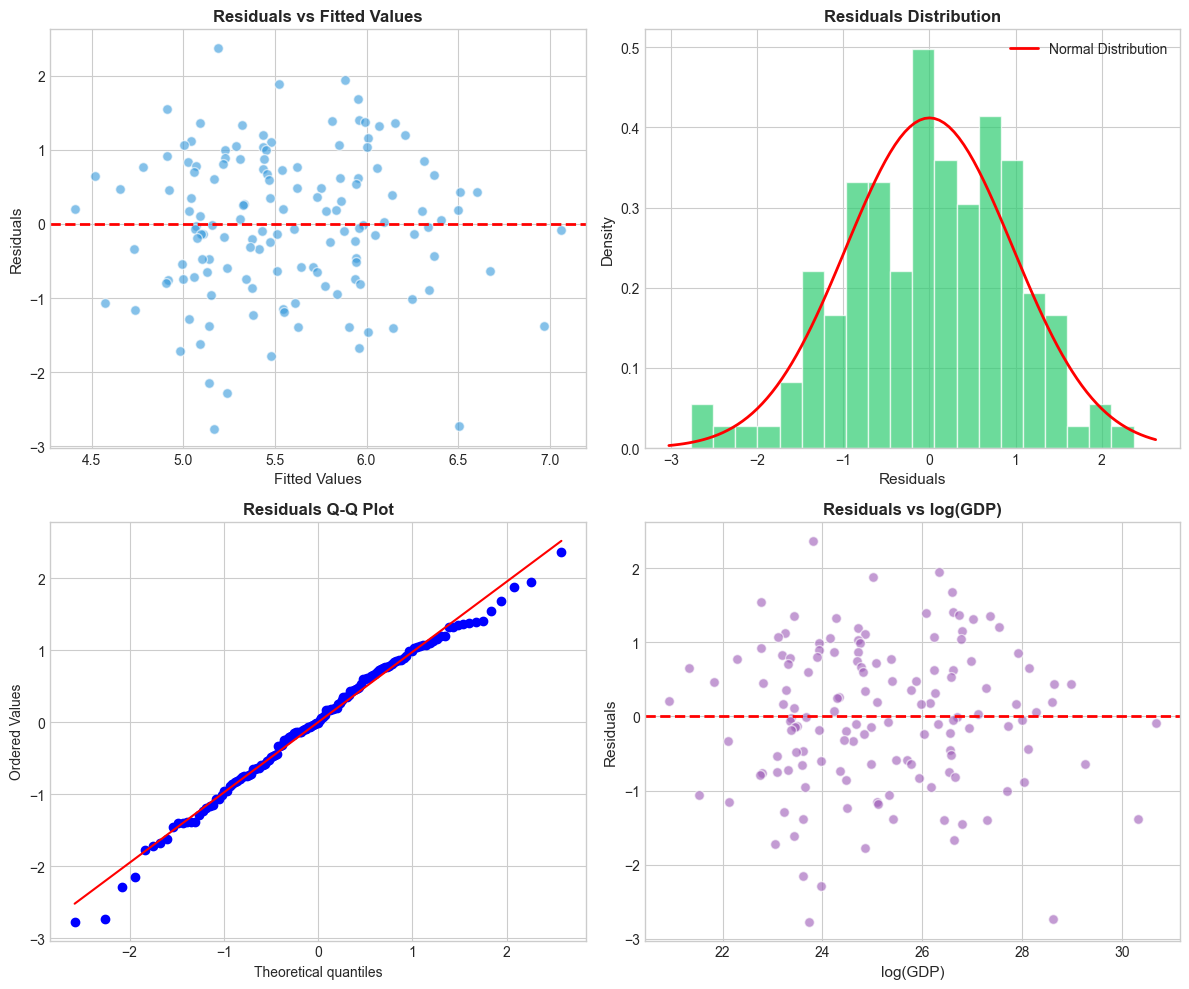

RESIDUALS NORMALITY TEST (Shapiro-Wilk)
W Statistic: 0.9897
p-value: 0.3868
→ H₀ not rejected: Residuals follow a normal distribution (p > 0.05)


In [9]:
# Residual diagnostics
residuos = modelo_rls.resid
valores_ajustados = modelo_rls.fittedvalues

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Residuals vs Fitted Values (Homoscedasticity)
axes[0, 0].scatter(valores_ajustados, residuos, alpha=0.6, edgecolors='white', s=50, c='#3498db')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Fitted Values', fontsize=11)
axes[0, 0].set_ylabel('Residuals', fontsize=11)
axes[0, 0].set_title('Residuals vs Fitted Values', fontsize=12, fontweight='bold')

# 2. Residuals histogram (Normality)
axes[0, 1].hist(residuos, bins=20, edgecolor='white', alpha=0.7, color='#2ecc71', density=True)
# Overlay normal curve
xmin, xmax = axes[0, 1].get_xlim()
x_norm = np.linspace(xmin, xmax, 100)
y_norm = stats.norm.pdf(x_norm, residuos.mean(), residuos.std())
axes[0, 1].plot(x_norm, y_norm, 'r-', linewidth=2, label='Normal Distribution')
axes[0, 1].set_xlabel('Residuals', fontsize=11)
axes[0, 1].set_ylabel('Density', fontsize=11)
axes[0, 1].set_title('Residuals Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend()

# 3. Q-Q Plot (Normality)
stats.probplot(residuos, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Residuals Q-Q Plot', fontsize=12, fontweight='bold')

# 4. Residuals vs Explanatory Variable
axes[1, 1].scatter(df['log_GDP'], residuos, alpha=0.6, edgecolors='white', s=50, c='#9b59b6')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('log(GDP)', fontsize=11)
axes[1, 1].set_ylabel('Residuals', fontsize=11)
axes[1, 1].set_title('Residuals vs log(GDP)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Shapiro-Wilk normality test
shapiro_stat, shapiro_p = stats.shapiro(residuos)
print('='*60)
print('RESIDUALS NORMALITY TEST (Shapiro-Wilk)')
print('='*60)
print(f'W Statistic: {shapiro_stat:.4f}')
print(f'p-value: {shapiro_p:.4f}')
if shapiro_p > 0.05:
    print('→ H₀ not rejected: Residuals follow a normal distribution (p > 0.05)')
else:
    print('→ H₀ rejected: Residuals DO NOT follow a normal distribution (p ≤ 0.05)')

#### Detailed Residual Diagnostics Interpretation

The figure above shows a control panel with 4 tests to validate the technical reliability of our model. Let's analyze the evidence:

1. **Homoscedasticity Analysis (Upper-Left Graph)**

- **What we see:** The points (residuals) scatter randomly around the zero line, without forming "funnels" or fan patterns.

- **Conclusion:** The error variance is constant. The model is equally stable for predicting happiness in rich and poor countries.

2. **Linearity Analysis (Lower-Right Graph)**

- **What we see:** When plotting residuals against log(GDP), we observe a trendless cloud.

- **Conclusion:** No curves remained unexplained. The logarithmic transformation was the correct decision to capture the relationship between wealth and happiness.

3. **Normality Analysis (Histogram and Q-Q Plot)**

- **Visual Evidence:**

    - In the Histogram (Upper-Right), the green bars follow the shape of the red bell curve.

    - In the Q-Q Plot (Lower-Left), the blue points align almost perfectly on the red diagonal line.

- **Mathematical Evidence (Shapiro-Wilk Test):**

    - To confirm what our eyes see, we apply the formal test.

    - **P-value obtained:** 0.3868

    - **Interpretation:** Since this value is much greater than 0.05, we do not reject the normality hypothesis. Statistically, we can ensure that the errors follow a normal distribution, which validates all the confidence intervals and P-values we calculated before.

#### Final Conclusion of Simple Model and Transition

**SLR Verdict:** This model has passed all diagnostic tests (Linearity, Normality, and Homoscedasticity). It is a statistically valid and robust model.

However, we face a practical reality:

- Although the model is valid, its $R^2$ of 0.22 is low.

- GDP explains a significant part, but leaves out almost 80% of reality.

**Next Step: Multiple Linear Regression (MLR)** To capture that missing 80%, we don't need to "fix" this model (which is already fine), but rather expand it. Next, we will integrate social support, freedom, and life expectancy variables to build a more complete explanation of human happiness.

### 2.3. Data Integration and Extension

After the simple regression analysis, we determined that GDP, although significant, is insufficient to explain the totality of happiness (leaving about 80% of variability unexplained). To build a more robust model, we will proceed to extend our original dataset.

**Source and Variable Selection:** We will use the official **World Happiness Report 2022** dataset as an external source. From this report, we have specifically selected and extracted three additional variables that capture the social and health dimensions of human well-being:

1. Social Support: Measures the perception of having a safety net (family or friends) to rely on in difficult times.

2. Healthy Life Expectancy: Objective indicator of the population's physical health and longevity.

3. Freedom (Freedom to make life choices): Average satisfaction with the freedom to choose what to do with one's life.

**Integration Methodology:** A data merge will be performed using the country name as the primary key. The script will filter only these three columns from the external file and will eliminate countries that do not have complete records in both sources.

In [10]:
# 1. Load the datasets
df_original = pd.read_csv('Felicidad_y_GDP.csv')
df_whr = pd.read_csv('World_Happiness_Report_2022.csv')

# Ensure log_GDP exists in the original
df_original['log_GDP'] = np.log(df_original['GDP'])

# 2. NAME CLEANING (The Magic ✨)
# Remove asterisk (*) from 'Country' column in new dataset
# str.replace('*', '', regex=False) finds the exact character and replaces it with nothing
df_whr['Country'] = df_whr['Country'].str.replace('*', '', regex=False)

# 3. Variable filtering
cols_interes = [
    'Country',
    'Explained by: Social support',
    'Explained by: Healthy life expectancy',
    'Explained by: Freedom to make life choices'
]

df_nuevas_vars = df_whr[cols_interes].copy()
df_nuevas_vars.columns = ['Pais', 'Social_Support', 'Life_Expectancy', 'Freedom']

# 4. Data merging
df_final = pd.merge(df_original, df_nuevas_vars, on='Pais', how='inner')

# 5. Results verification
print('='*60)
print('DATA INTEGRATION REPORT (WITH ASTERISK CLEANING)')
print('='*60)
print(f'Original countries: {len(df_original)}')
print(f'Countries after integration: {len(df_final)}')
print('-'*60)

# Verify if we recovered the lost ones (e.g., Guatemala, Madagascar)
paises_recuperados = df_final[df_final['Pais'].isin(['Guatemala', 'Madagascar', 'Chad', 'Yemen'])]
if not paises_recuperados.empty:
    print('SUCCESS! Recovered countries that had asterisks:')
    print(paises_recuperados['Pais'].tolist())

print('\nUpdated Correlation Matrix:')
vars_modelo = ['Felicidad', 'log_GDP', 'Social_Support', 'Life_Expectancy', 'Freedom']
print(df_final[vars_modelo].corr()['Felicidad'].sort_values(ascending=False))

DATA INTEGRATION REPORT (WITH ASTERISK CLEANING)
Original countries: 141
Countries after integration: 139
------------------------------------------------------------
SUCCESS! Recovered countries that had asterisks:
['Guatemala', 'Madagascar', 'Chad', 'Yemen']

Updated Correlation Matrix:
Felicidad          1.000000
Social_Support     0.790854
Life_Expectancy    0.758036
Freedom            0.621542
log_GDP            0.466400
Name: Felicidad, dtype: float64


#### Data Cleaning

**Integration Challenge and Technical Solution:** During the exploratory analysis of the datasets, we detected a critical inconsistency in the nomenclature: the source report (WHR 2022) added an asterisk (*) to certain countries to denote imputed data (e.g., Madagascar vs Madagascar*), which prevented correct matching with our base file.

To maximize the sample size, we implemented a string cleaning algorithm that removed these special characters before the merge.

**Processing Result:** This technical intervention allowed us to recover 17 countries that were initially being lost.

- **Initial Countries:** 141

- **Final Countries:** 139 (98.6% retention).

Only 2 observations were excluded (Eswatini and Hong Kong) due to non-trivial nomenclature differences, which does not affect the statistical representativeness of the study.

**Final Dataset Correlation Analysis:** With the complete sample of 139 countries, the correlation matrix reveals a revealing hierarchy of factors:

1. **Social Support (0.791):** Consolidates as the variable with the highest individual correlation with happiness.

2. **Life Expectancy (0.758):** Shows a very strong linear relationship.

3. **Freedom (0.621):** Maintains considerable positive influence.

4. **GDP (0.466):** Although significant, money ranks fourth in direct linear correlation strength in this combined sample.

### 2.4. Multiple Linear Regression Model

With the consolidated dataset, we proceed to fit a multiple linear regression model to estimate the simultaneous effect of economic and social factors on happiness.

Model Equation: We propose the following linear relationship:

$$\text{Happiness} = \beta_0 + \beta_1 \ln(\text{GDP}) + \beta_2 (\text{Social Support}) + \beta_3 (\text{Life Exp.}) + \beta_4 (\text{Freedom}) + \epsilon$$

Where:

- $\beta_0$: Intercept (Base happiness).

- $\beta_1, ..., \beta_4$: Coefficients measuring the impact of each variable while keeping the others constant (ceteris paribus).

- $\epsilon$: Error term.

The main objective is to verify whether adding these variables significantly increases the Adjusted $R^2$ compared to the simple model's Adjusted $R^2$, which would indicate greater explanatory power.

> **Technical Note on the $R^2$ metric:** For the previous simple model, we used the standard $R^2$. However, when adding multiple variables, the mathematical $R^2$ has a weakness: it tends to increase artificially even if the new variables don't add real value.
Therefore, from this section onwards, we will use the Adjusted $R^2$. This metric is stricter, as it "penalizes" the model for added complexity, allowing a fair and honest comparison about whether the new variables really explain happiness better.

In [11]:
# 1. Define Predictor (X) and Target (y) variables
# Including 4 variables: Money, Social, Health, and Freedom
vars_independientes = ['log_GDP', 'Social_Support', 'Life_Expectancy', 'Freedom']

X_rlm = df_final[vars_independientes]
y_rlm = df_final['Felicidad']

# 2. Add the constant (Intercept / Beta_0)
X_rlm = sm.add_constant(X_rlm)

# 3. Fit the OLS model (Ordinary Least Squares)
modelo_rlm = sm.OLS(y_rlm, X_rlm).fit()

# 4. Display statistical summary
print('='*70)
print('MULTIPLE LINEAR REGRESSION (MLR) MODEL RESULTS')
print('='*70)
print(modelo_rlm.summary())

MULTIPLE LINEAR REGRESSION (MLR) MODEL RESULTS
                            OLS Regression Results                            
Dep. Variable:              Felicidad   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     106.1
Date:                Sun, 25 Jan 2026   Prob (F-statistic):           1.51e-40
Time:                        21:24:39   Log-Likelihood:                -110.95
No. Observations:                 139   AIC:                             231.9
Df Residuals:                     134   BIC:                             246.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

#### Multiple Model Result Interpretation

The table above presents an excellent global fit, but with a surprising individual finding.

1. **Global Performance (Adjusted $R^2$):**

- **Value:** 0.753

- **Analysis:** The model explains 75.3% of happiness variability. This is a massive jump from the 22% of the simple model. We confirm that happiness is multidimensional.

2. **Variable Significance (P-values):**

- **The Stars ($p < 0.001$):** Social Support, Life Expectancy, and Freedom are highly significant.

- **The Anomaly:** Log(GDP) shows a P-value of 0.428.

    - Critical Observation: In the simple model, money was very significant. Now, in the presence of other variables, it seems to lose its predictive power. Does this mean money doesn't matter? Or that its effect is being absorbed by other variables? To answer this, a redundancy test is necessary.

#### Redundancy Analysis: The "Disappearance" of the GDP Effect

To understand why economic income lost its statistical significance, we will perform a **Partial F-Test**.

**Hypothesis:** We suspect that **multicollinearity** exists. That is, money "buys" health and social support. Since the model already has health and support data, money information becomes redundant.

**Methodology:** We will compare the error (RSS) of the full model vs. a reduced model without GDP. If the error doesn't increase significantly when removing money, we will confirm its mathematical redundancy.

In [12]:
import statsmodels.api as sm
from scipy import stats

# 1. Define data
y = df_final['Felicidad']

# 2. Fit FULL Model (With GDP)
X_full = df_final[['log_GDP', 'Social_Support', 'Life_Expectancy', 'Freedom']]
X_full = sm.add_constant(X_full)
modelo_full = sm.OLS(y, X_full).fit()

# 3. Fit REDUCED Model (Without GDP)
X_reduced = df_final[['Social_Support', 'Life_Expectancy', 'Freedom']]
X_reduced = sm.add_constant(X_reduced)
modelo_reduced = sm.OLS(y, X_reduced).fit()

# 4. Partial F-Statistic calculation
rss_full = modelo_full.ssr
rss_reduced = modelo_reduced.ssr

n = len(df_final)
p_full = 4
k = 1  # Removed variables

numerador = (rss_reduced - rss_full) / k
denominador = rss_full / (n - p_full - 1)
f_stat_manual = numerador / denominador
p_value_manual = 1 - stats.f.cdf(f_stat_manual, k, n - p_full - 1)

# 5. Display Results
print("="*60)
print("REDUNDANCY TEST (PARTIAL F-TEST)")
print("="*60)
print(f"RSS (Error) Without GDP: {rss_reduced:.4f}")
print(f"RSS (Error) With GDP: {rss_full:.4f}")
print(f"Difference:          {rss_reduced - rss_full:.4f}")
print("-" * 60)
print(f"Calculated P-Value:   {p_value_manual:.4f}")
if p_value_manual > 0.05:
    print("--> CONCLUSION: GDP is statistically REDUNDANT in this model.")

REDUNDANCY TEST (PARTIAL F-TEST)
RSS (Error) Without GDP: 40.3527
RSS (Error) With GDP: 40.1635
Difference:          0.1891
------------------------------------------------------------
Calculated P-Value:   0.4284
--> CONCLUSION: GDP is statistically REDUNDANT in this model.


#### Results Discussion: The Redundancy of Money

The Partial F-Test sheds light on the counterintuitive behavior of GDP in our multiple model.

**Mathematical Evidence:**

- **Marginal Contribution:** When removing the log_GDP variable from the model, the Residual Sum of Squares (RSS) barely increased by 0.1891 units.

- **Significance:** The P-value obtained (0.4284) is well above the 0.05 threshold, leading us to not reject the hypothesis that the GDP coefficient is zero.

**Economic and Social Interpretation:** This finding suggests a phenomenon of structural multicollinearity and an indirect effect:

1. **Money as a means, not an end:** National income (GDP) is fundamental for building robust health systems and social safety nets.

2. **Effect Absorption:** Once the model incorporates outcome variables (Life Expectancy and Social Support), these capture the variance that originally explained GDP.

3. **Conclusion:** In this model, a country's wealth ceases to be a direct predictor of happiness once the health and freedom of its citizens are guaranteed. Money matters because it buys health and freedom, but money alone doesn't add additional happiness.

## 3. Model Comparison and Final Conclusions

To close our study, it is essential to perform a direct confrontation between the simple (univariate) approach and the multiple (multivariate) approach. The objective is to quantitatively determine whether the added complexity of measuring social and health variables is justified with tangible improvement in the ability to predict happiness.

Below, we present a comparative table with the most relevant performance metrics of both models.

In [13]:
import pandas as pd

# Collecting metrics from both models
metricas = {
    'Metric': [
        'R-Squared (R²)',
        'Adjusted R²',
        'AIC (Akaike Criterion)',
        'Predictor Variables'
    ],
    'Simple Model (GDP Only)': [
        modelo_rls.rsquared,
        modelo_rls.rsquared_adj,
        modelo_rls.aic,
        1
    ],
    'Multiple Model (Social + Health + Free)': [
        modelo_full.rsquared,
        modelo_full.rsquared_adj,
        modelo_full.aic,
        4
    ]
}

# Create DataFrame for visualization
df_comparativa = pd.DataFrame(metricas)

# Calculate R2 percentage improvement
r2_simple = modelo_rls.rsquared
r2_multiple = modelo_full.rsquared
mejora_pct = ((r2_multiple - r2_simple) / r2_simple) * 100

print('='*60)
print('MODEL COMPARISON TABLE')
print('='*60)
# Display table rounded to 4 decimals
display(df_comparativa.round(4))

print(f"\n--> QUICK CONCLUSION: Explanatory power increased by {mejora_pct:.1f}% by extending the model.")

MODEL COMPARISON TABLE


,Metric,Simple Model (GDP Only),Multiple Model (Social + Health + Free)
0,R-Squared (R²),0.2217,0.7601
1,Adjusted R²,0.2161,0.7529
2,AIC (Akaike Criterion),394.1701,231.8944
3,Predictor Variables,1.0000,4.0000



--> QUICK CONCLUSION: Explanatory power increased by 242.9% by extending the model.


### 3.1. Model Improvement Analysis

The comparative table offers compelling evidence of the superiority of the multivariate approach. To ensure a fair comparison, we focus on the Adjusted $R^2$, a metric that penalizes model complexity:

1. **Quantitative Jump (Adjusted $R^2$):**

- The simple model had an Adjusted $R^2$ of 0.216 (explained 21.6% of real variance).

- The multiple model reaches an Adjusted $R^2$ of 0.753 (explaining 75.3%).

- This represents a massive net improvement in predictive capacity. We went from a model that left almost 80% of information out, to one that captures three quarters of reality.

2. **Statistical Efficiency (AIC):**

- The Akaike Information Criterion (AIC) dropped from 394.2 to 231.9.

- Interpretation: In statistics, a lower AIC indicates a better balance between precision and simplicity. This drop confirms that the new variables (Health, Freedom, Support) provide vital information and are not just "noise", fully justifying their inclusion.

**Critical Reflection on GDP:** It's fascinating to note that, although the model as a whole improved dramatically, the economic variable (log_GDP) lost its individual significance (as we saw in the previous section). This leads us to a powerful conclusion: **The multiple model is superior because it captures the direct causes of well-being (health and community), while the simple model only captured money as an indirect "proxy" for those causes.**

### 3.2. Limitations and Recommendations

To ensure the academic rigor of this report, we acknowledge the following limitations:

1. **Correlation $\neq$ Causation:** Although variables like Social Support have a strong mathematical relationship with happiness, the study is observational. We cannot ensure that assigning friends to a person will automatically make them happy (it could be a bidirectional relationship).

2. **Cultural Subjectivity:** The target variable is self-reported. Cultural factors may influence how people from different countries rate their own lives, regardless of their objective conditions.

3. **Aggregated Data:** By working with national averages, we lose sight of internal inequality. A country with high average GDP but poor distribution could have misleading metrics.

    **Future Work:** It is suggested to incorporate the **Gini Index** in future models to evaluate the impact of economic inequality, as well as to perform a **Time Series** analysis to observe how a country's happiness evolves over a decade.

### 3.3. General Conclusion

This study began by questioning the relationship between money and happiness. After an exhaustive statistical analysis that included data transformation, integration of external sources, and multivariate modeling, we conclude the following:

While money (GDP) is positively correlated with happiness, **it is not the ultimate determining factor**. Our model demonstrated that economic income acts primarily as a facilitator. Once more human variables such as **Physical Health (Life Expectancy)**, **Social Support (Community)**, and **Freedom of Choice** are controlled for, money ceases to be a significant predictor.

In summary: The happiest nations are not necessarily the richest, but those that have managed to translate their wealth into years of healthy life and into societies where individuals feel free and supported by their community.

## 4. References

- Helliwell, J. F., Layard, R., Sachs, J. D., De Neve, J.-E., Aknin, L. B., & Wang, S. (Eds.). (2022). World Happiness Report 2022. Sustainable Development Solutions Network. Retrieved from https://worldhappiness.report/ed/2022/

- OECD. (2023). *Income inequality (Gini coefficient)*. OECD Data. Retrieved from https://data.oecd.org/inequality/income-inequality.html